In [1]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns

from reardon import RACE_WEIGHT, RACES, RES_LOC, RES_STD, run

sns.set_context("notebook", font_scale=1.25)
sns.set_style("darkgrid")

plt.rcParams["figure.dpi"] = 150

In [2]:
def run_agg_colls(num_repeats=10, **kwargs):
    runs_ = Parallel(n_jobs=-1, verbose=1)(
        delayed(run)(**kwargs) for _ in range(num_repeats)
    )
    colls, _, _, _ = zip(*runs_)
    # average of runs
    colls = np.rec.fromarrays(
        [
            np.mean([colls_[name] for colls_ in colls], axis=0)
            for name in colls[0].dtype.names
        ],
        dtype=colls[0].dtype,
    )
    # as dataframe
    ind_yc = pd.MultiIndex.from_product(
        (range(colls.shape[0]), range(colls.shape[1])), names=["year", "coll"]
    )
    colls = pd.DataFrame(colls.ravel(), index=ind_yc)
    return colls


coll_0_0_0 = run_agg_colls(num_years=50, wgt_aa_race=0, wgt_aa_ses=0, wgt_recr_race=0)
coll_260_0_0 = run_agg_colls(
    num_years=50, wgt_aa_race=260, wgt_aa_ses=0, wgt_recr_race=0
)
coll_0_150_100 = run_agg_colls(
    num_years=50, wgt_aa_race=0, wgt_aa_ses=150, wgt_recr_race=100
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.7s finished


In [3]:
def plot_pct_minority(coll):
    f, ax = plt.subplots()
    sns.lineplot(
        x="year",
        y="pct_minority",
        hue="active",
        units="coll",
        data=coll,
        estimator=None,
        legend=False,
        lw=0.5,
        ax=ax,
    )
    sns.lineplot(
        x="year",
        y="pct_minority",
        hue="active",
        data=coll,
        legend=False,
        lw=5,
        ci=None,
        ax=ax,
    )
    ax.set(xlabel="Year", ylabel="Percent minority")
    return f


def plot_quality(coll):
    f, ax = plt.subplots()
    sns.lineplot(
        x="year",
        y="qual",
        hue="active",
        units="coll",
        data=coll,
        estimator=None,
        legend=False,
        lw=0.5,
        ax=ax,
    )
    sns.lineplot(
        x="year", y="qual", hue="active", data=coll, legend=False, lw=5, ci=None, ax=ax
    )
    ax.set(xlabel="Year", ylabel="College quality")
    return f


def my_quiver(ax, rows, x, y, z, t0, t1):
    for _, row in rows:
        ax.annotate(
            "",
            xy=(row[(x, t1)], row[(y, t1)]),
            xytext=(row[(x, t0)], row[(y, t0)]),
            arrowprops=dict(arrowstyle="->", ec=sns.color_palette()[int(row[(z, t0)])]),
        )


def plot_minority_mach(coll):
    df = coll[coll.index.get_level_values("year").isin([14, 29])].reset_index()
    f, ax = plt.subplots()
    sns.scatterplot(
        x="ach_mean", y="pct_minority", hue="active", data=df, legend=False, s=0, ax=ax
    )
    my_quiver(
        ax,
        df.set_index(["year", "coll"]).unstack("year").iterrows(),
        "ach_mean",
        "pct_minority",
        "active",
        14,
        29,
    )
    ax.set(
        xlabel="Mean achievement of enrolled students",
        ylabel="Proportion minority students",
    )
    return f

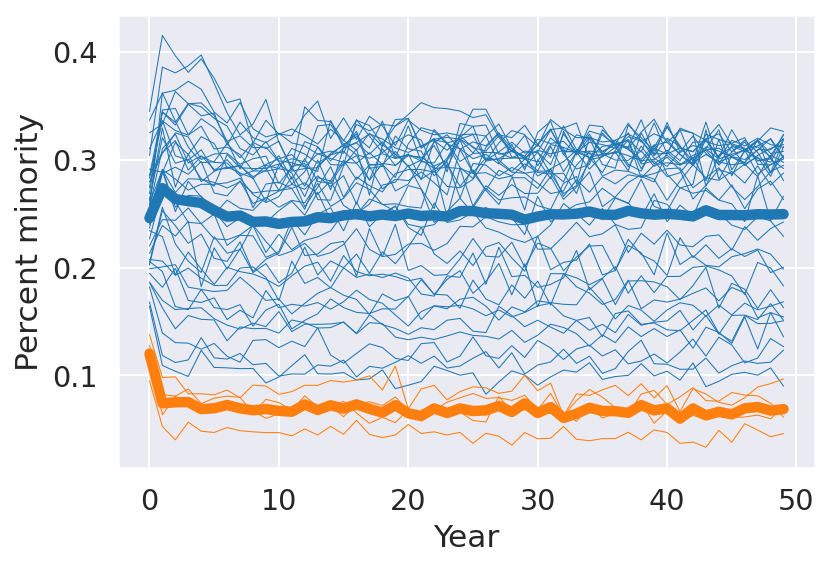

In [4]:
plot_pct_minority(coll_0_0_0).savefig("figures/figC1.png", bbox_inches="tight")

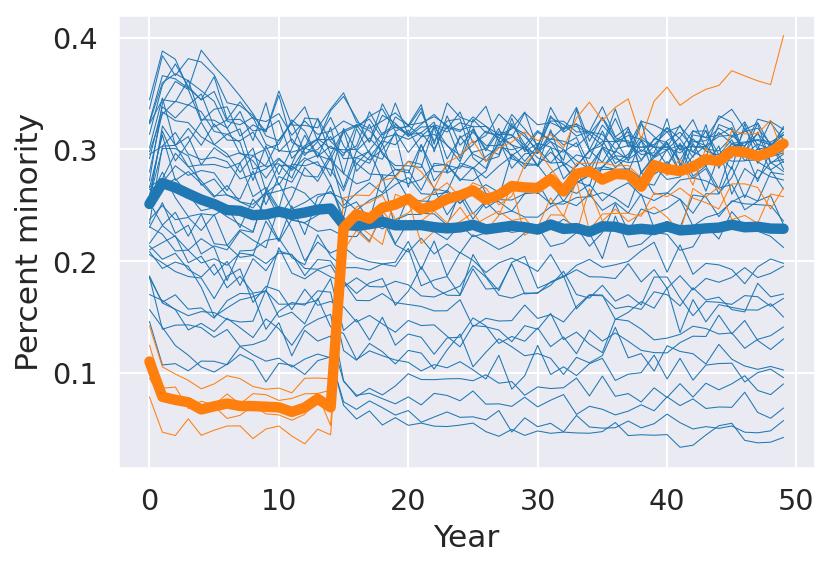

In [5]:
plot_pct_minority(coll_260_0_0).savefig("figures/figC2.png", bbox_inches="tight")

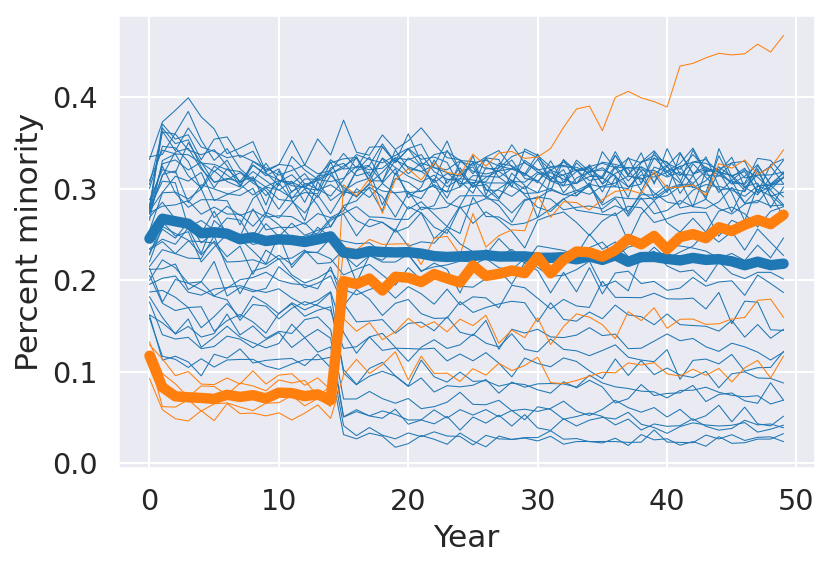

In [6]:
plot_pct_minority(coll_0_150_100).savefig("figures/figC4.png", bbox_inches="tight")

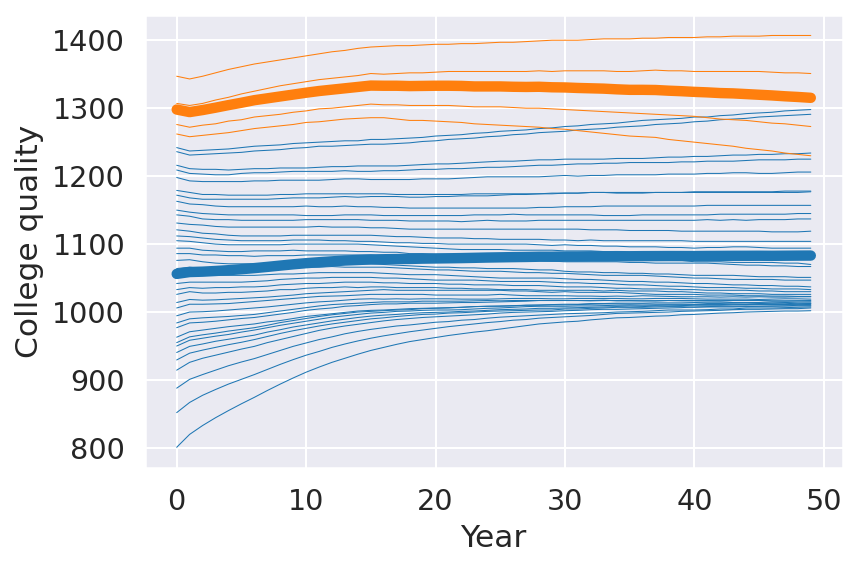

In [7]:
plot_quality(coll_0_150_100).savefig("figures/figC5.png", bbox_inches="tight")

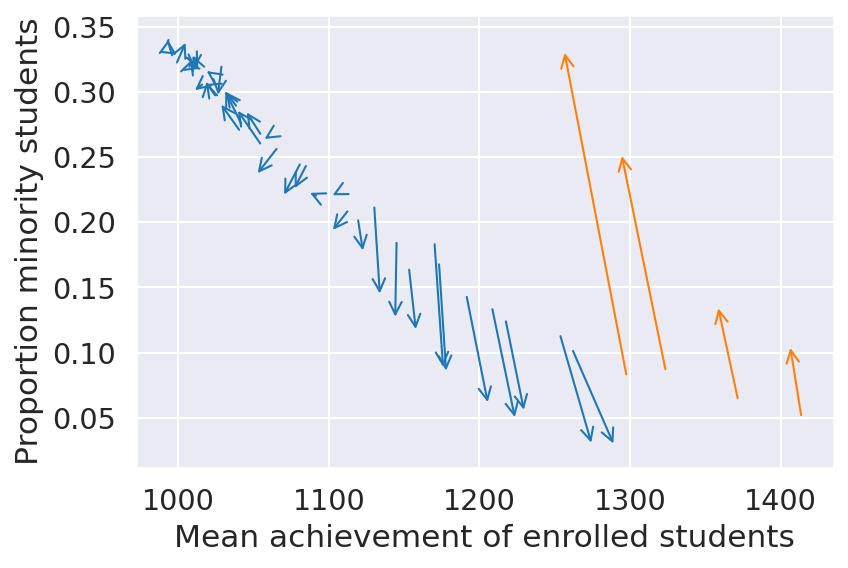

In [8]:
plot_minority_mach(coll_0_150_100).savefig("figures/fig3A.png", bbox_inches="tight")

In [9]:
def enr_by_race(**kwargs):
    _, _, _, enr = run(**kwargs)
    enr = enr[(enr.year >= 25) & enr.active]
    _, c = np.unique(enr.race, return_counts=True)
    return c * 100 / np.sum(c)


# same resources quintiles for every runs
res_loc_ = np.sum(RACE_WEIGHT * RES_LOC)
res_var = np.sum(RACE_WEIGHT * (RES_STD**2 + RES_LOC**2 - res_loc_**2))
q = np.linspace(0, 1, 5 + 1)
res_q = norm.ppf(q, loc=res_loc_, scale=np.sqrt(res_var))
res_q_names = [f"Q{i}" for i in range(1, 5 + 1)]


def enr_by_qres(**kwargs):
    _, _, _, enr = run(**kwargs)
    enr = enr[(enr.year >= 25) & enr.active]
    c, _ = np.histogram(enr.res, bins=res_q)
    return c * 100 / np.sum(c)

In [10]:
df_fig2 = pd.MultiIndex.from_product(
    ([0, 50, 100, 150], [0, 25, 50, 100]), names=["wgt_aa_ses", "wgt_recr_race"]
).to_frame(index=False)

runs = Parallel(n_jobs=-1, verbose=1)(
    delayed(enr_by_race)(**conf) for _, conf in df_fig2.iterrows()
)
df_fig2[RACES] = runs

# as a share real-world AA
real_world = enr_by_race(wgt_aa_race=260)
df_fig2[RACES] = df_fig2[RACES] / real_world

df_fig2 = df_fig2.melt(
    id_vars=["wgt_aa_ses", "wgt_recr_race"],
    var_name="Race",
    value_name="Composition (%)",
)
df_fig2.columns = ["SES weight", "Recruit weight", "Race", "Rel. enrollment"]

df_fig2 = df_fig2[df_fig2.Race.isin(["Black", "Hispanic"])]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   23.2s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   32.0s finished


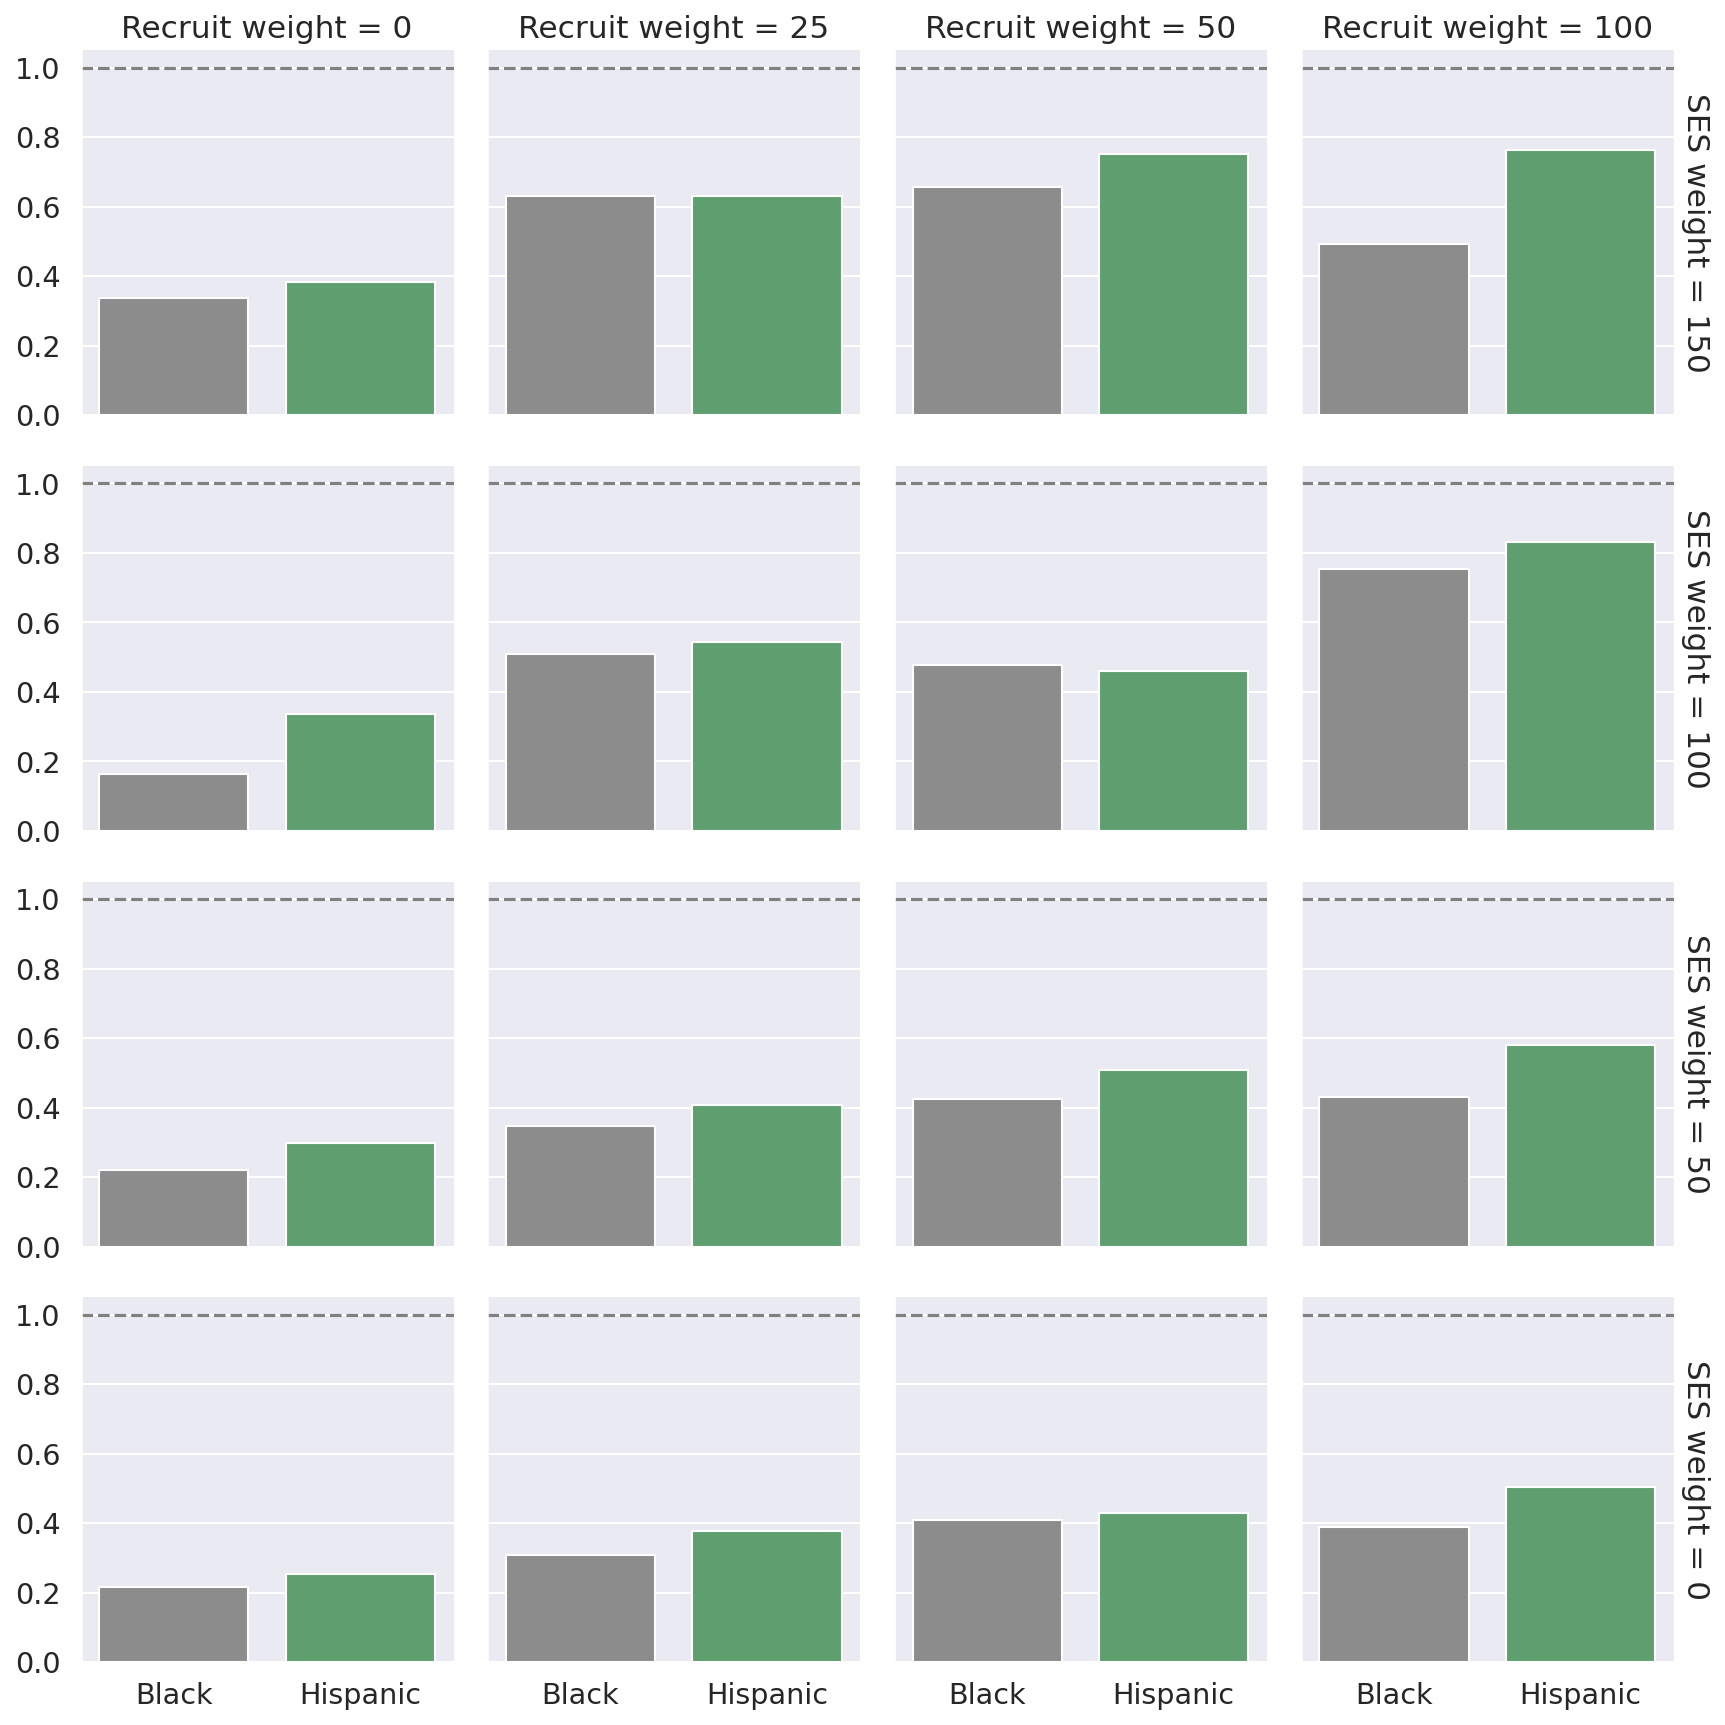

In [11]:
g = sns.catplot(
    x="Race",
    y="Rel. enrollment",
    col="Recruit weight",
    row="SES weight",
    data=df_fig2,
    kind="bar",
    margin_titles=True,
    row_order=[150, 100, 50, 0],
    height=3,
    palette=["#8c8c8c", "#55a868"],
)
g.refline(y=1)
g.set_axis_labels("", "")
g.savefig("figures/fig2.png", bbox_inches="tight")

In [12]:
df_figA2 = pd.MultiIndex.from_product(
    ([0, 75, 150], [25, 50, 100]), names=["wgt_aa_ses", "wgt_recr_race"]
).to_frame(index=False)

runs = Parallel(n_jobs=-1, verbose=1)(
    delayed(enr_by_race)(**conf) for _, conf in df_figA2.iterrows()
)
df_figA2[RACES] = runs

df_figA2 = df_figA2.melt(
    id_vars=["wgt_aa_ses", "wgt_recr_race"],
    var_name="Race",
    value_name="Composition (%)",
)
df_figA2.columns = ["SES weight", "Recruit weight", "Race", "Composition (%)"]

reardon_figA2 = pd.DataFrame(
    {
        "SES weight": [0, 0, 0, 75, 75, 75, 150, 150, 150],
        "Recruit weight": [25, 50, 100, 25, 50, 100, 25, 50, 100],
        "Black": [3, 3.5, 3.9, 5, 5.5, 6.4, 6.7, 7.6, 9],
        "Hispanic": [5.9, 6.7, 7.6, 9.3, 11, 13, 13, 15, 17],
        "Asian": [7.5, 7.3, 7.4, 7.2, 7, 6.9, 7, 6.7, 6.2],
        "White": [84, 82, 81, 78, 77, 74, 73, 71, 67],
    }
)
reardon_figA2 = reardon_figA2.melt(
    id_vars=["SES weight", "Recruit weight"],
    var_name="Race",
    value_name="Composition (%)",
)

df_figA2 = (
    pd.concat(
        [df_figA2, reardon_figA2], keys=["Replication", "Original"], names=["Source"]
    )
    .droplevel(1)
    .reset_index()
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   16.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.5s finished


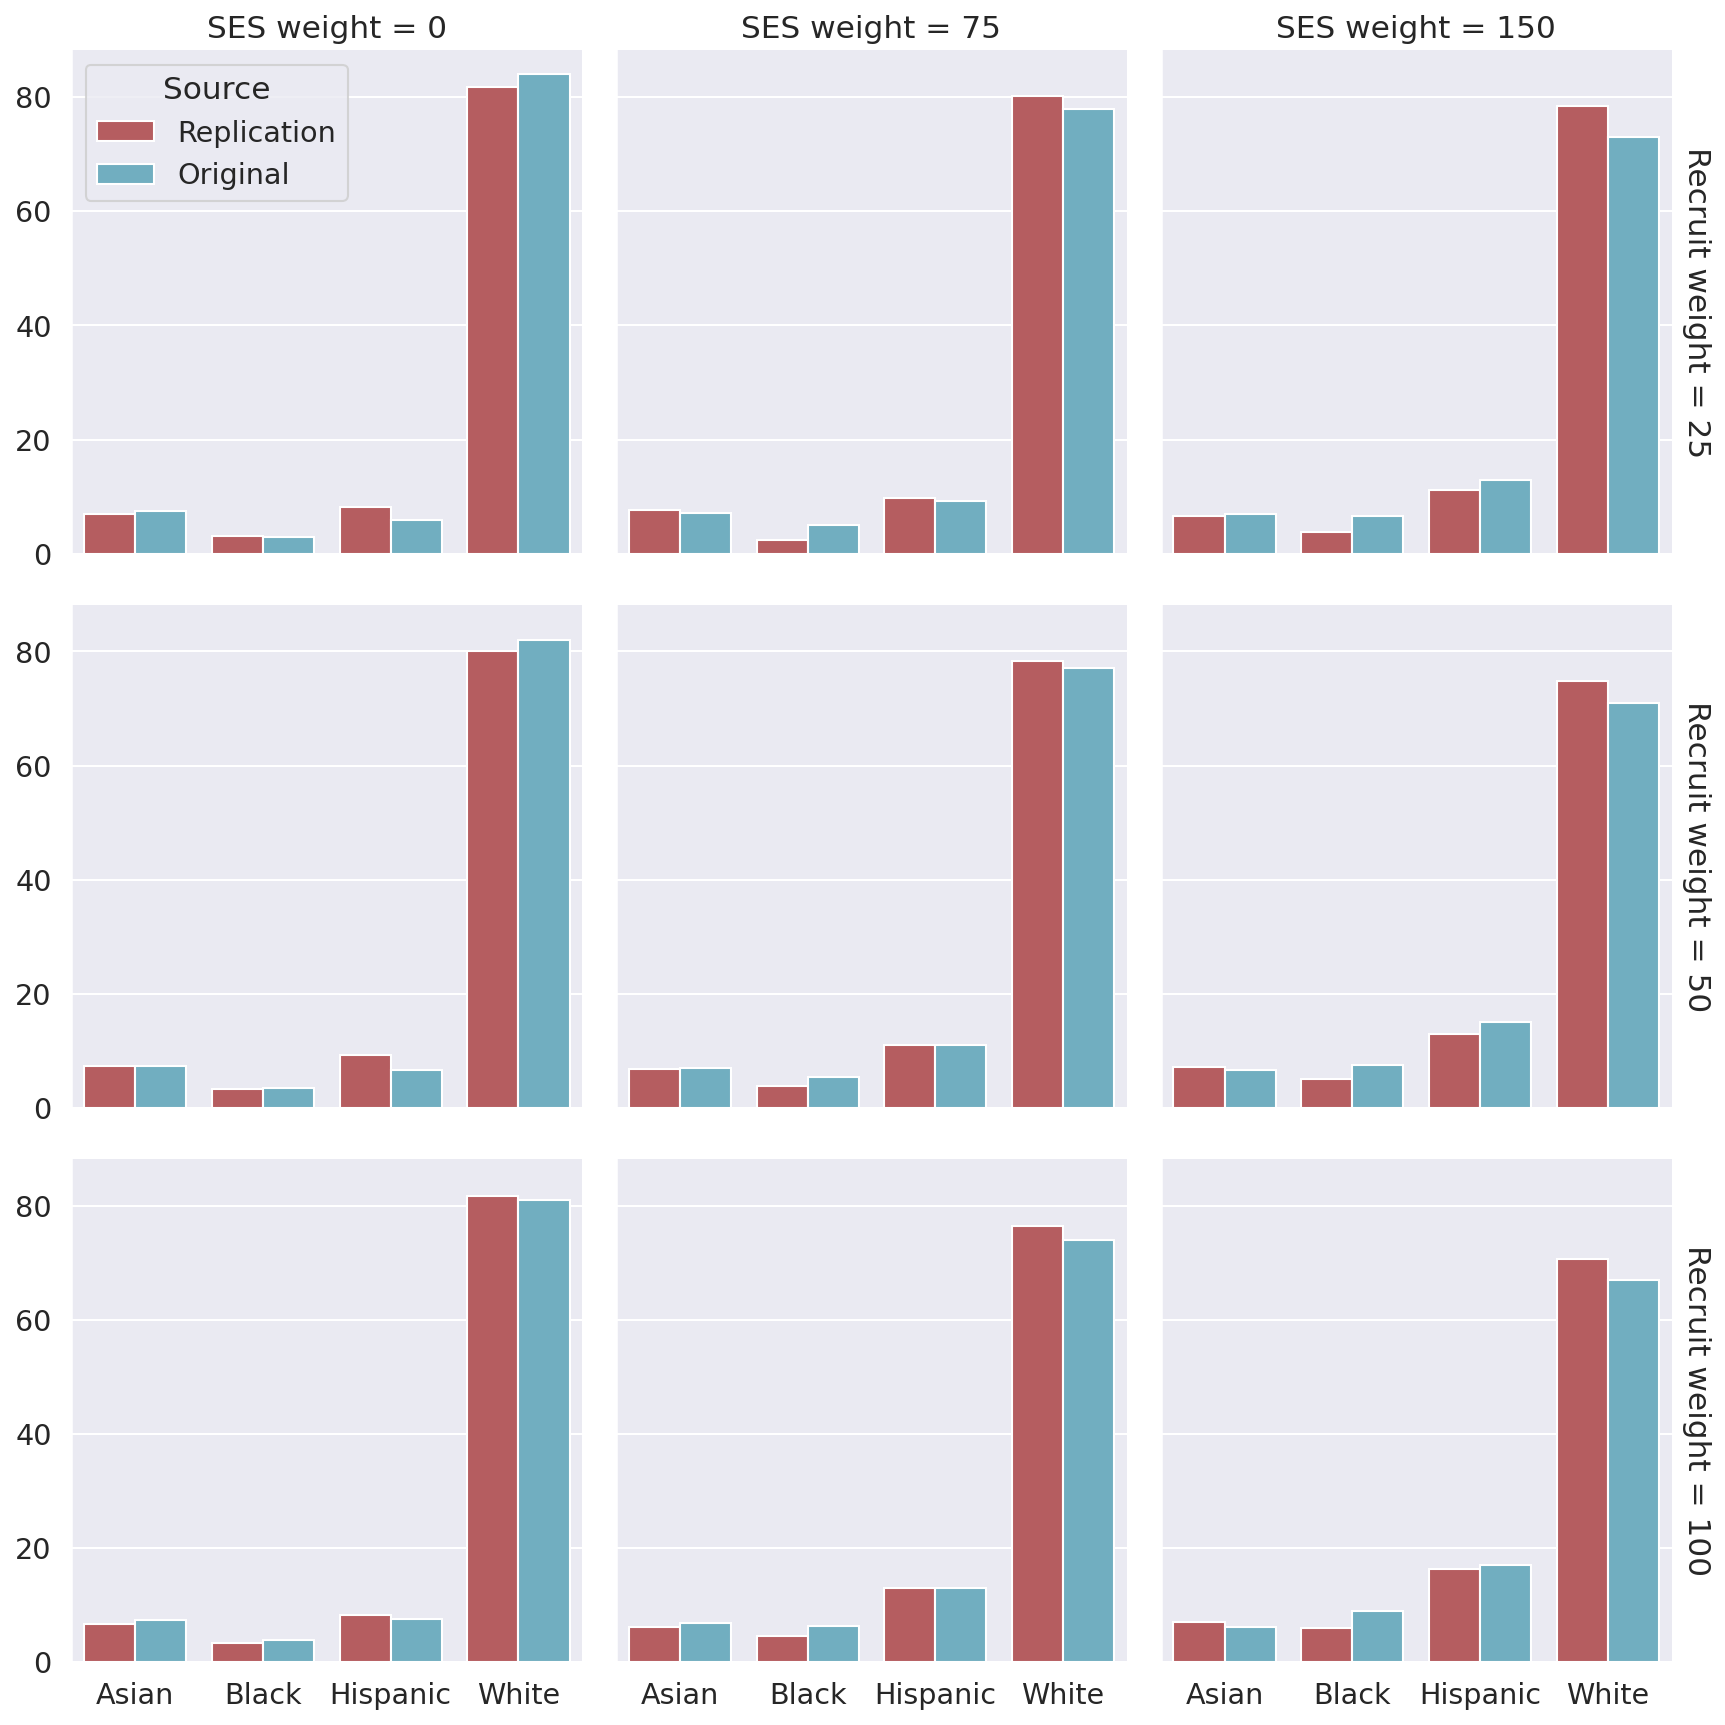

In [13]:
g = sns.catplot(
    x="Race",
    y="Composition (%)",
    hue="Source",
    col="SES weight",
    row="Recruit weight",
    data=df_figA2,
    kind="bar",
    margin_titles=True,
    legend_out=False,
    height=4,
    palette=["#c44e52", "#64b5cd"],
)
g.set_axis_labels("", "")
g.figure.savefig("figures/figA2.png")

In [14]:
df_figA3 = pd.MultiIndex.from_product(
    ([0, 75, 150], [25, 50, 100]), names=["wgt_aa_ses", "wgt_recr_race"]
).to_frame(index=False)

runs = Parallel(n_jobs=-1, verbose=1)(
    delayed(enr_by_qres)(**conf) for _, conf in df_figA3.iterrows()
)
df_figA3[res_q_names] = runs

df_figA3 = df_figA3.melt(
    id_vars=["wgt_aa_ses", "wgt_recr_race"],
    var_name="Resources",
    value_name="Composition (%)",
)
df_figA3.columns = ["SES weight", "Recruit weight", "Resources", "Composition (%)"]

reardon_figA3 = pd.DataFrame(
    {
        "SES weight": [0, 0, 0, 75, 75, 75, 150, 150, 150],
        "Recruit weight": [25, 50, 100, 25, 50, 100, 25, 50, 100],
        "Q1": [1.7, 1.8, 1.9, 6.8, 7, 7.7, 11, 12, 13],
        "Q2": [5.7, 5.8, 6, 12, 12, 13, 16, 16, 17],
        "Q3": [12, 12, 12, 17, 17, 17, 19, 20, 19],
        "Q4": [23, 22, 22, 24, 24, 24, 24, 23, 23],
        "Q5": [58, 58, 58, 40, 39, 38, 30, 29, 27],
    }
)
reardon_figA3 = reardon_figA3.melt(
    id_vars=["SES weight", "Recruit weight"],
    var_name="Resources",
    value_name="Composition (%)",
)

df_figA3 = (
    pd.concat(
        [df_figA3, reardon_figA3],
        keys=["Replication", "Original"],
        names=["Source"],
    )
    .droplevel(1)
    .reset_index()
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   16.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.3s finished


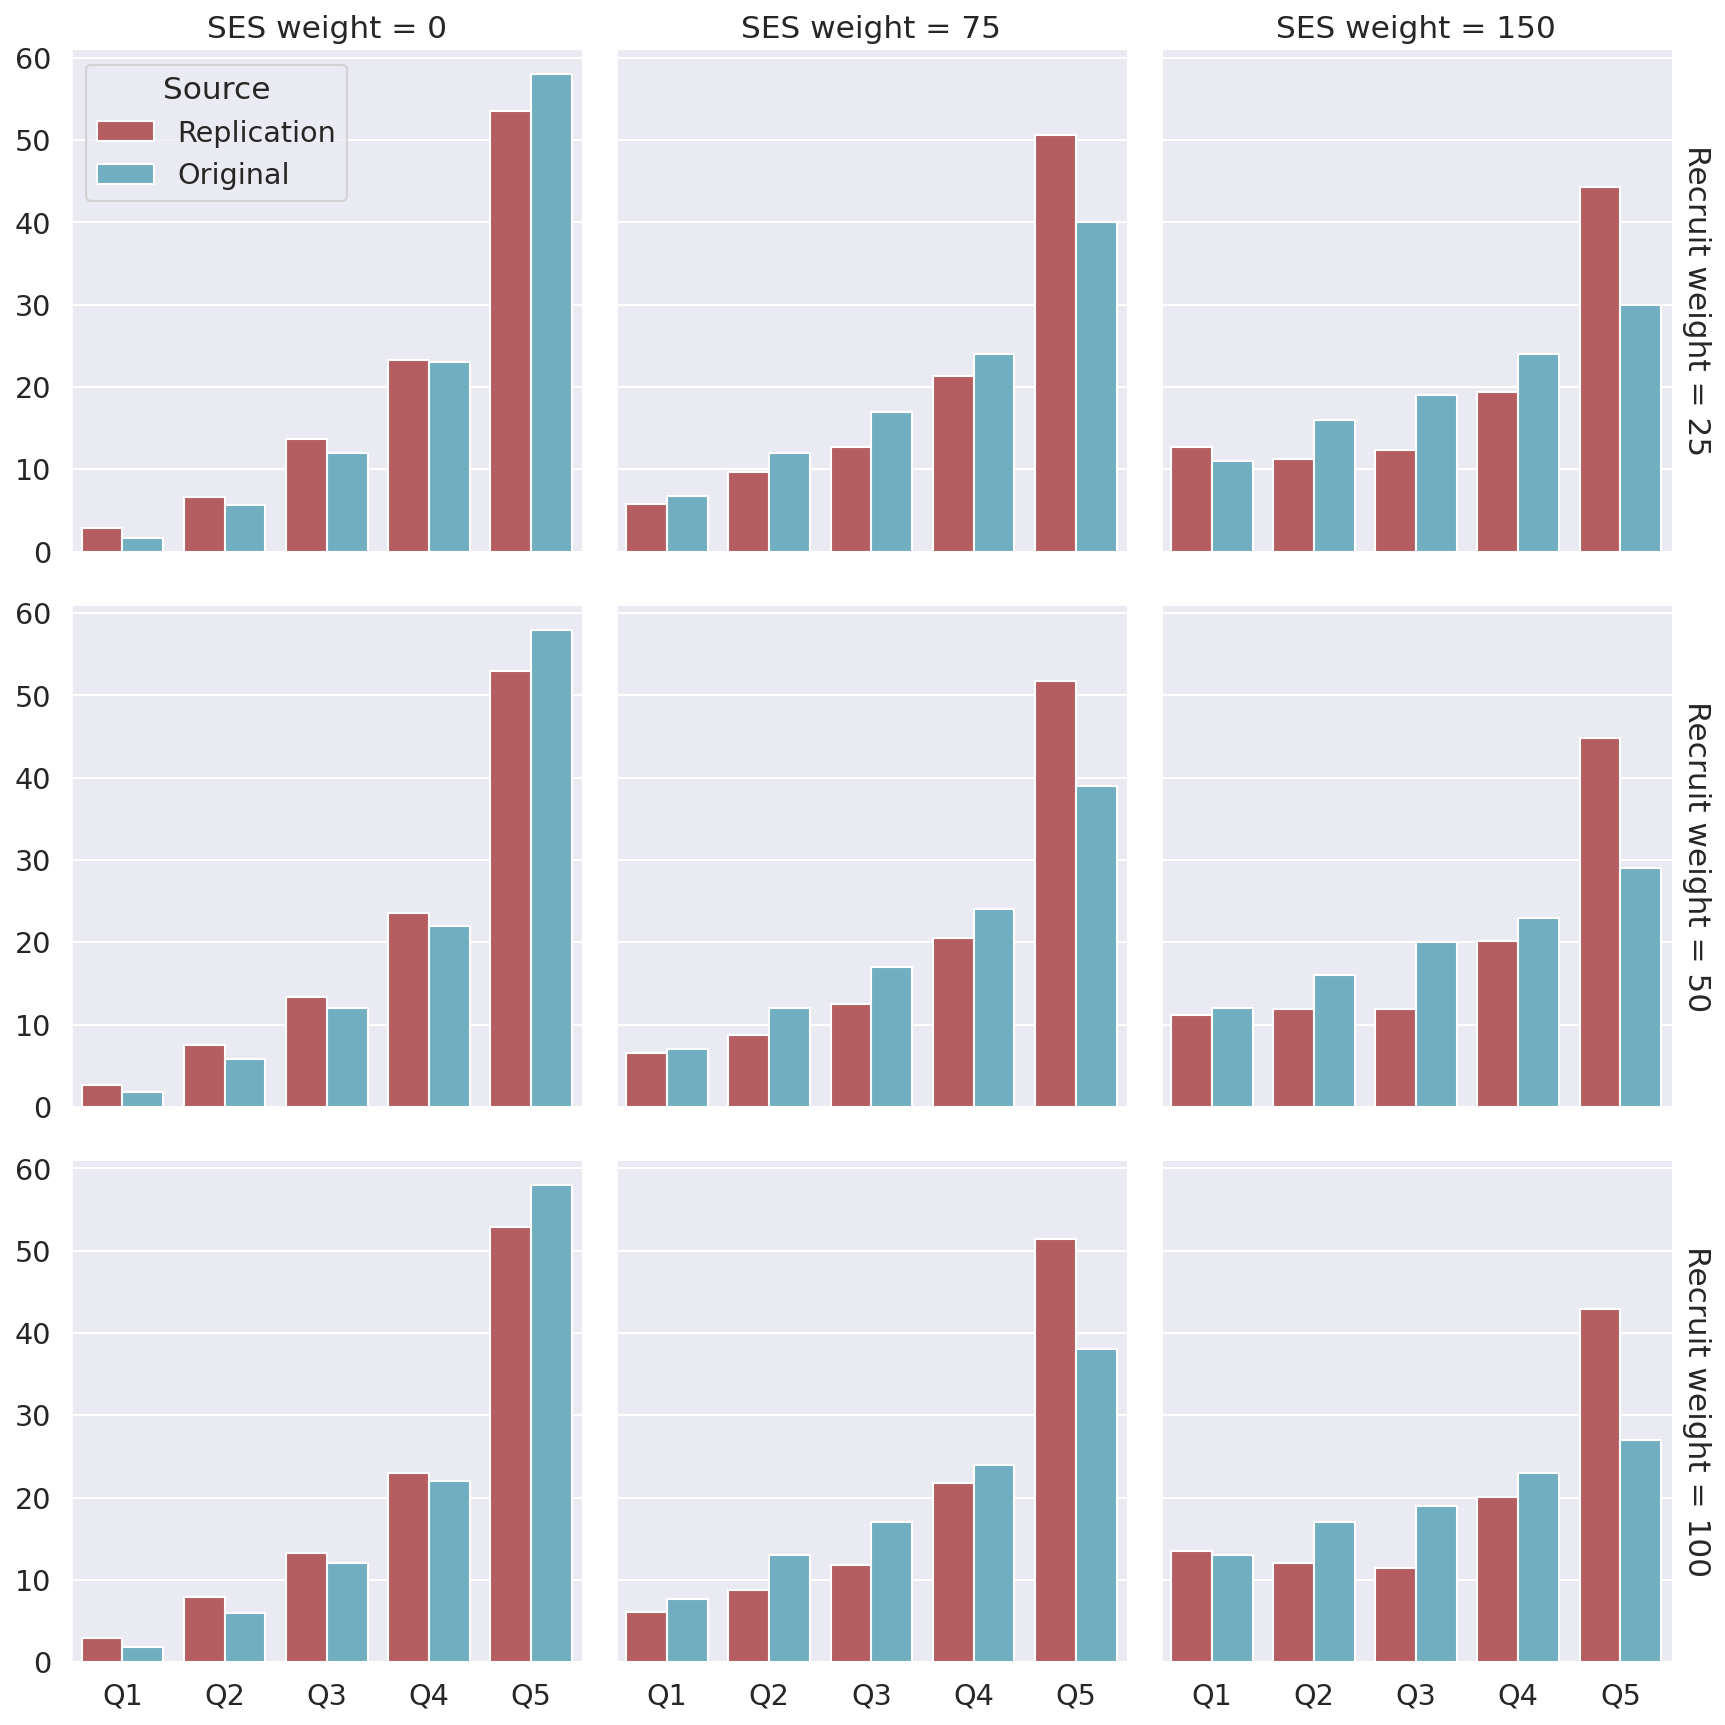

In [15]:
g = sns.catplot(
    x="Resources",
    y="Composition (%)",
    hue="Source",
    col="SES weight",
    row="Recruit weight",
    data=df_figA3,
    kind="bar",
    margin_titles=True,
    legend_out=False,
    height=4,
    palette=["#c44e52", "#64b5cd"],
)
g.set_axis_labels("", "")
g.figure.savefig("figures/figA3.png")

In [16]:
df_figA4 = pd.MultiIndex.from_product(
    ([0, 75, 150], [0, 150, 300]), names=["wgt_aa_ses", "wgt_aa_race"]
).to_frame(index=False)

runs = Parallel(n_jobs=-1, verbose=1)(
    delayed(enr_by_race)(**conf) for _, conf in df_figA4.iterrows()
)
df_figA4[RACES] = runs

df_figA4 = df_figA4.melt(
    id_vars=["wgt_aa_ses", "wgt_aa_race"], var_name="Race", value_name="Composition (%)"
)
df_figA4.columns = ["SES weight", "Race weight", "Race", "Composition (%)"]

reardon_figA4 = pd.DataFrame(
    {
        "SES weight": [0, 0, 0, 75, 150, 75, 150],
        "Race weight": [0, 150, 300, 0, 0, 150, 300],
        "Black": [1.9, 5.6, 11, 2.4, 3.4, 6.9, 16],
        "Hispanic": [3.9, 9.3, 15, 5.1, 6.8, 11, 22],
        "Asian": [8.6, 7.1, 6, 7.7, 7.4, 6.8, 5.1],
        "White": [86, 78, 68, 85, 82, 75, 57],
    }
)
reardon_figA4 = reardon_figA4.melt(
    id_vars=["SES weight", "Race weight"], var_name="Race", value_name="Composition (%)"
)

df_figA4 = (
    pd.concat(
        [df_figA4, reardon_figA4], keys=["Replication", "Original"], names=["Source"]
    )
    .droplevel(1)
    .reset_index()
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   16.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   17.0s finished


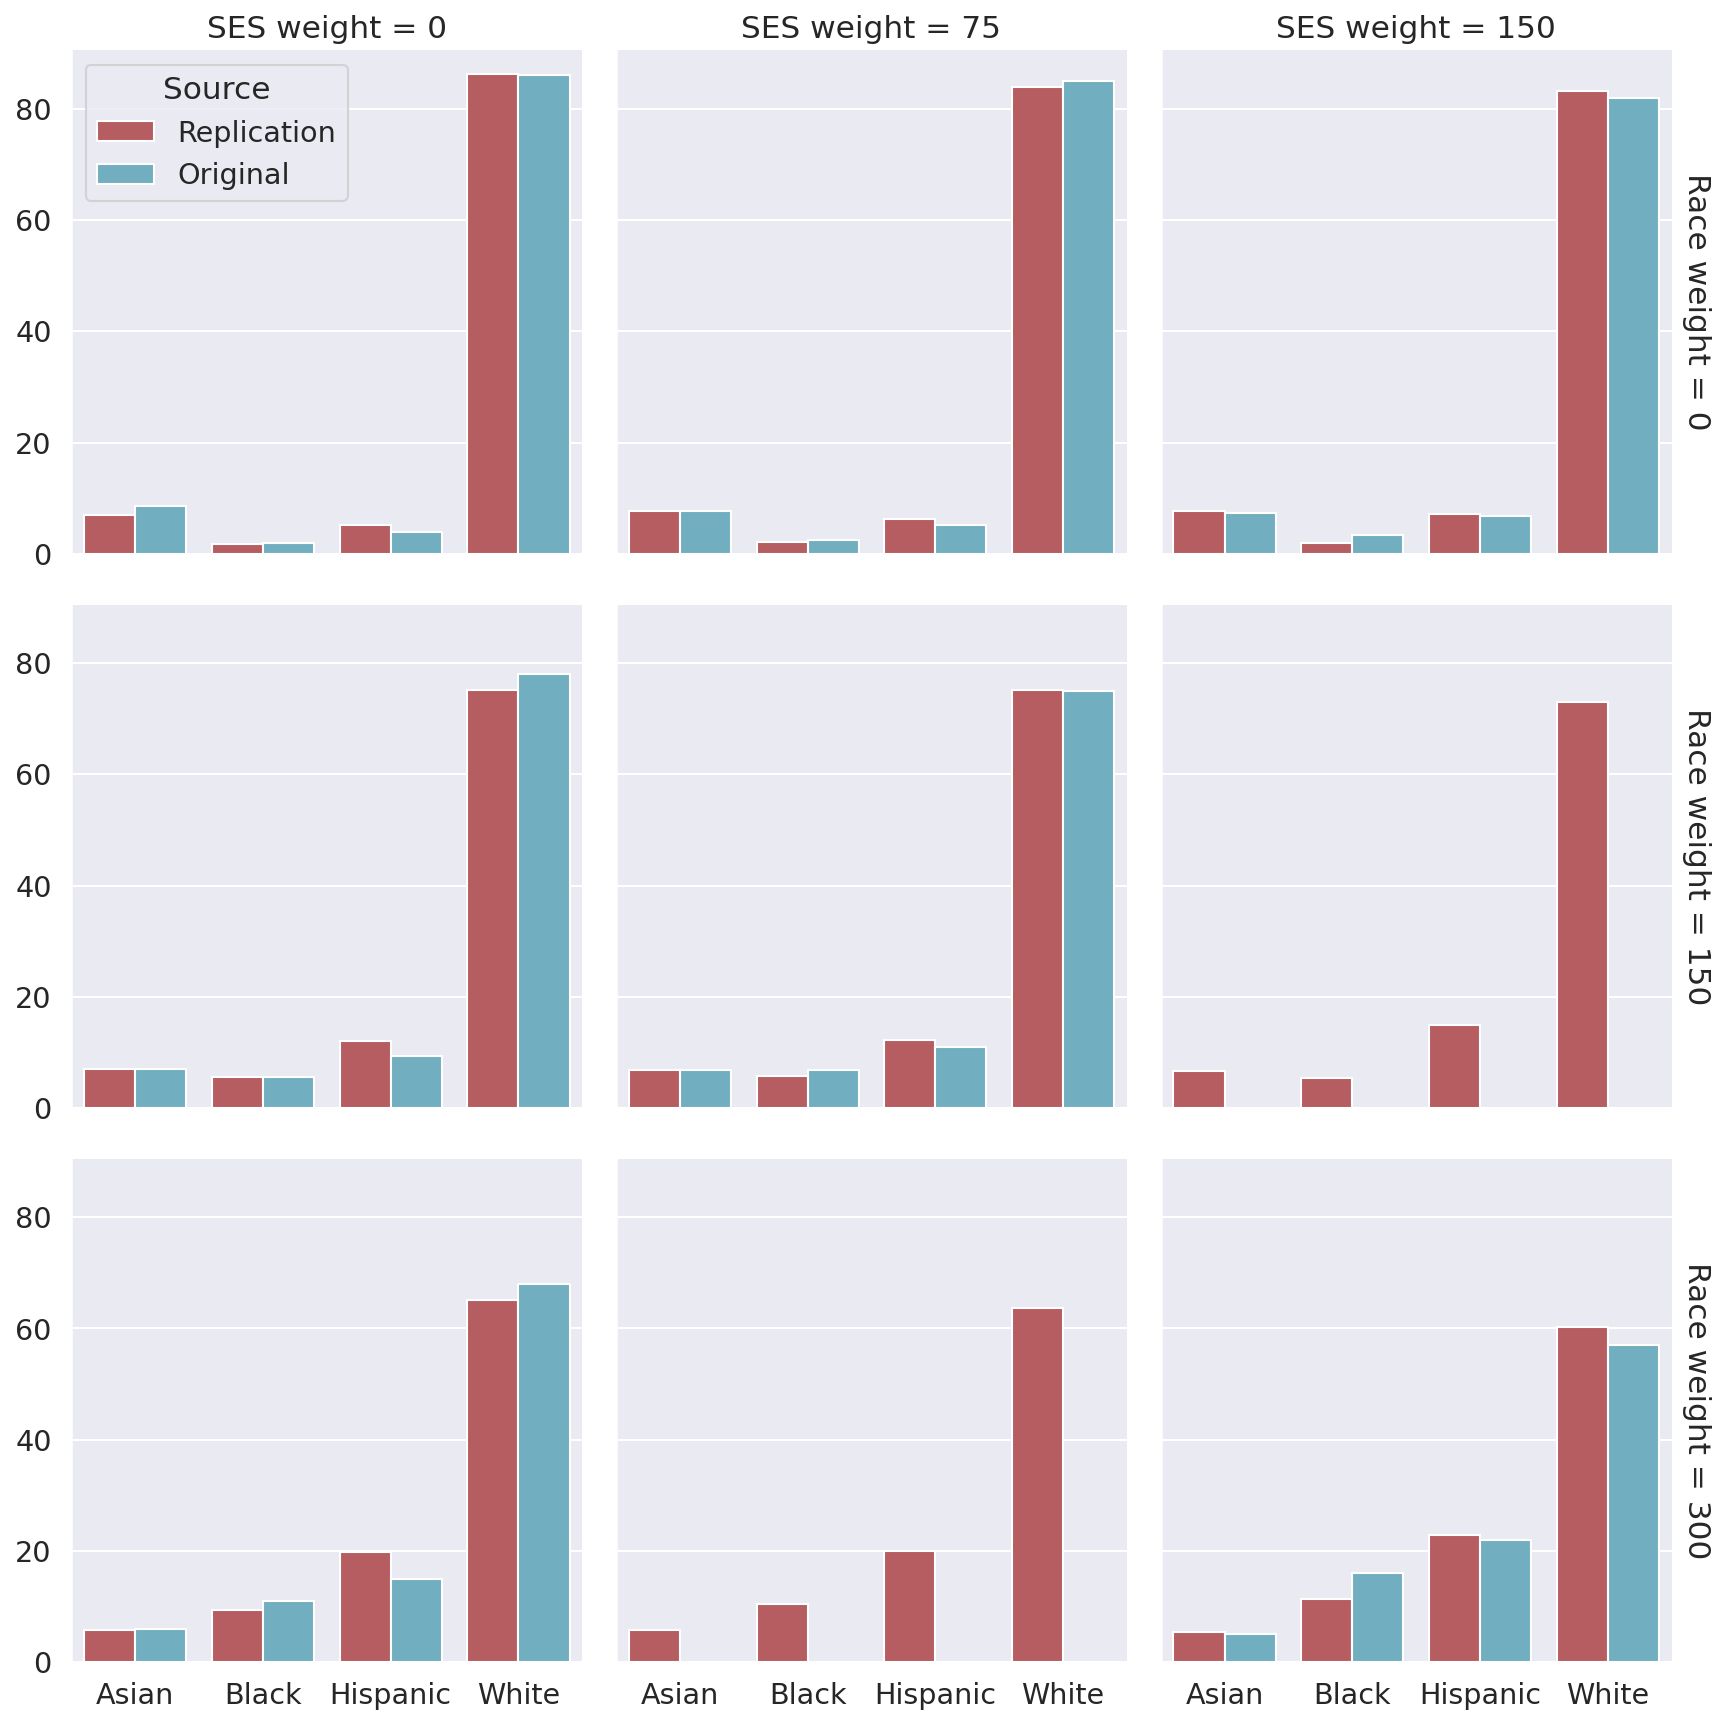

In [17]:
g = sns.catplot(
    x="Race",
    y="Composition (%)",
    hue="Source",
    col="SES weight",
    row="Race weight",
    data=df_figA4,
    kind="bar",
    margin_titles=True,
    legend_out=False,
    height=4,
    palette=["#c44e52", "#64b5cd"],
)
g.set_axis_labels("", "")
g.figure.savefig("figures/figA4.png")

In [18]:
df_figA5 = pd.MultiIndex.from_product(
    ([0, 75, 150], [0, 150, 300]), names=["wgt_aa_ses", "wgt_aa_race"]
).to_frame(index=False)

runs = Parallel(n_jobs=-1, verbose=1)(
    delayed(enr_by_qres)(**conf) for _, conf in df_figA5.iterrows()
)
df_figA5[res_q_names] = runs

df_figA5 = df_figA5.melt(
    id_vars=["wgt_aa_ses", "wgt_aa_race"],
    var_name="Resources",
    value_name="Composition (%)",
)
df_figA5.columns = ["SES weight", "Race weight", "Resources", "Composition (%)"]

reardon_figA5 = pd.DataFrame(
    {
        "SES weight": [0, 0, 0, 75, 150, 75, 150],
        "Race weight": [0, 150, 300, 0, 0, 150, 300],
        "Q1": [1.5, 2.4, 4.3, 4.1, 7.6, 5.5, 16],
        "Q2": [5.4, 6.6, 8.7, 9.2, 14, 11, 17],
        "Q3": [11, 12, 14, 15, 19, 16, 20],
        "Q4": [23, 23, 22, 25, 25, 24, 22],
        "Q5": [59, 56, 51, 47, 34, 44, 24],
    }
)
reardon_figA5 = reardon_figA5.melt(
    id_vars=["SES weight", "Race weight"],
    var_name="Resources",
    value_name="Composition (%)",
)

df_figA5 = (
    pd.concat(
        [df_figA5, reardon_figA5],
        keys=["Replication", "Original"],
        names=["Source"],
    )
    .droplevel(1)
    .reset_index()
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   17.7s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   18.1s finished


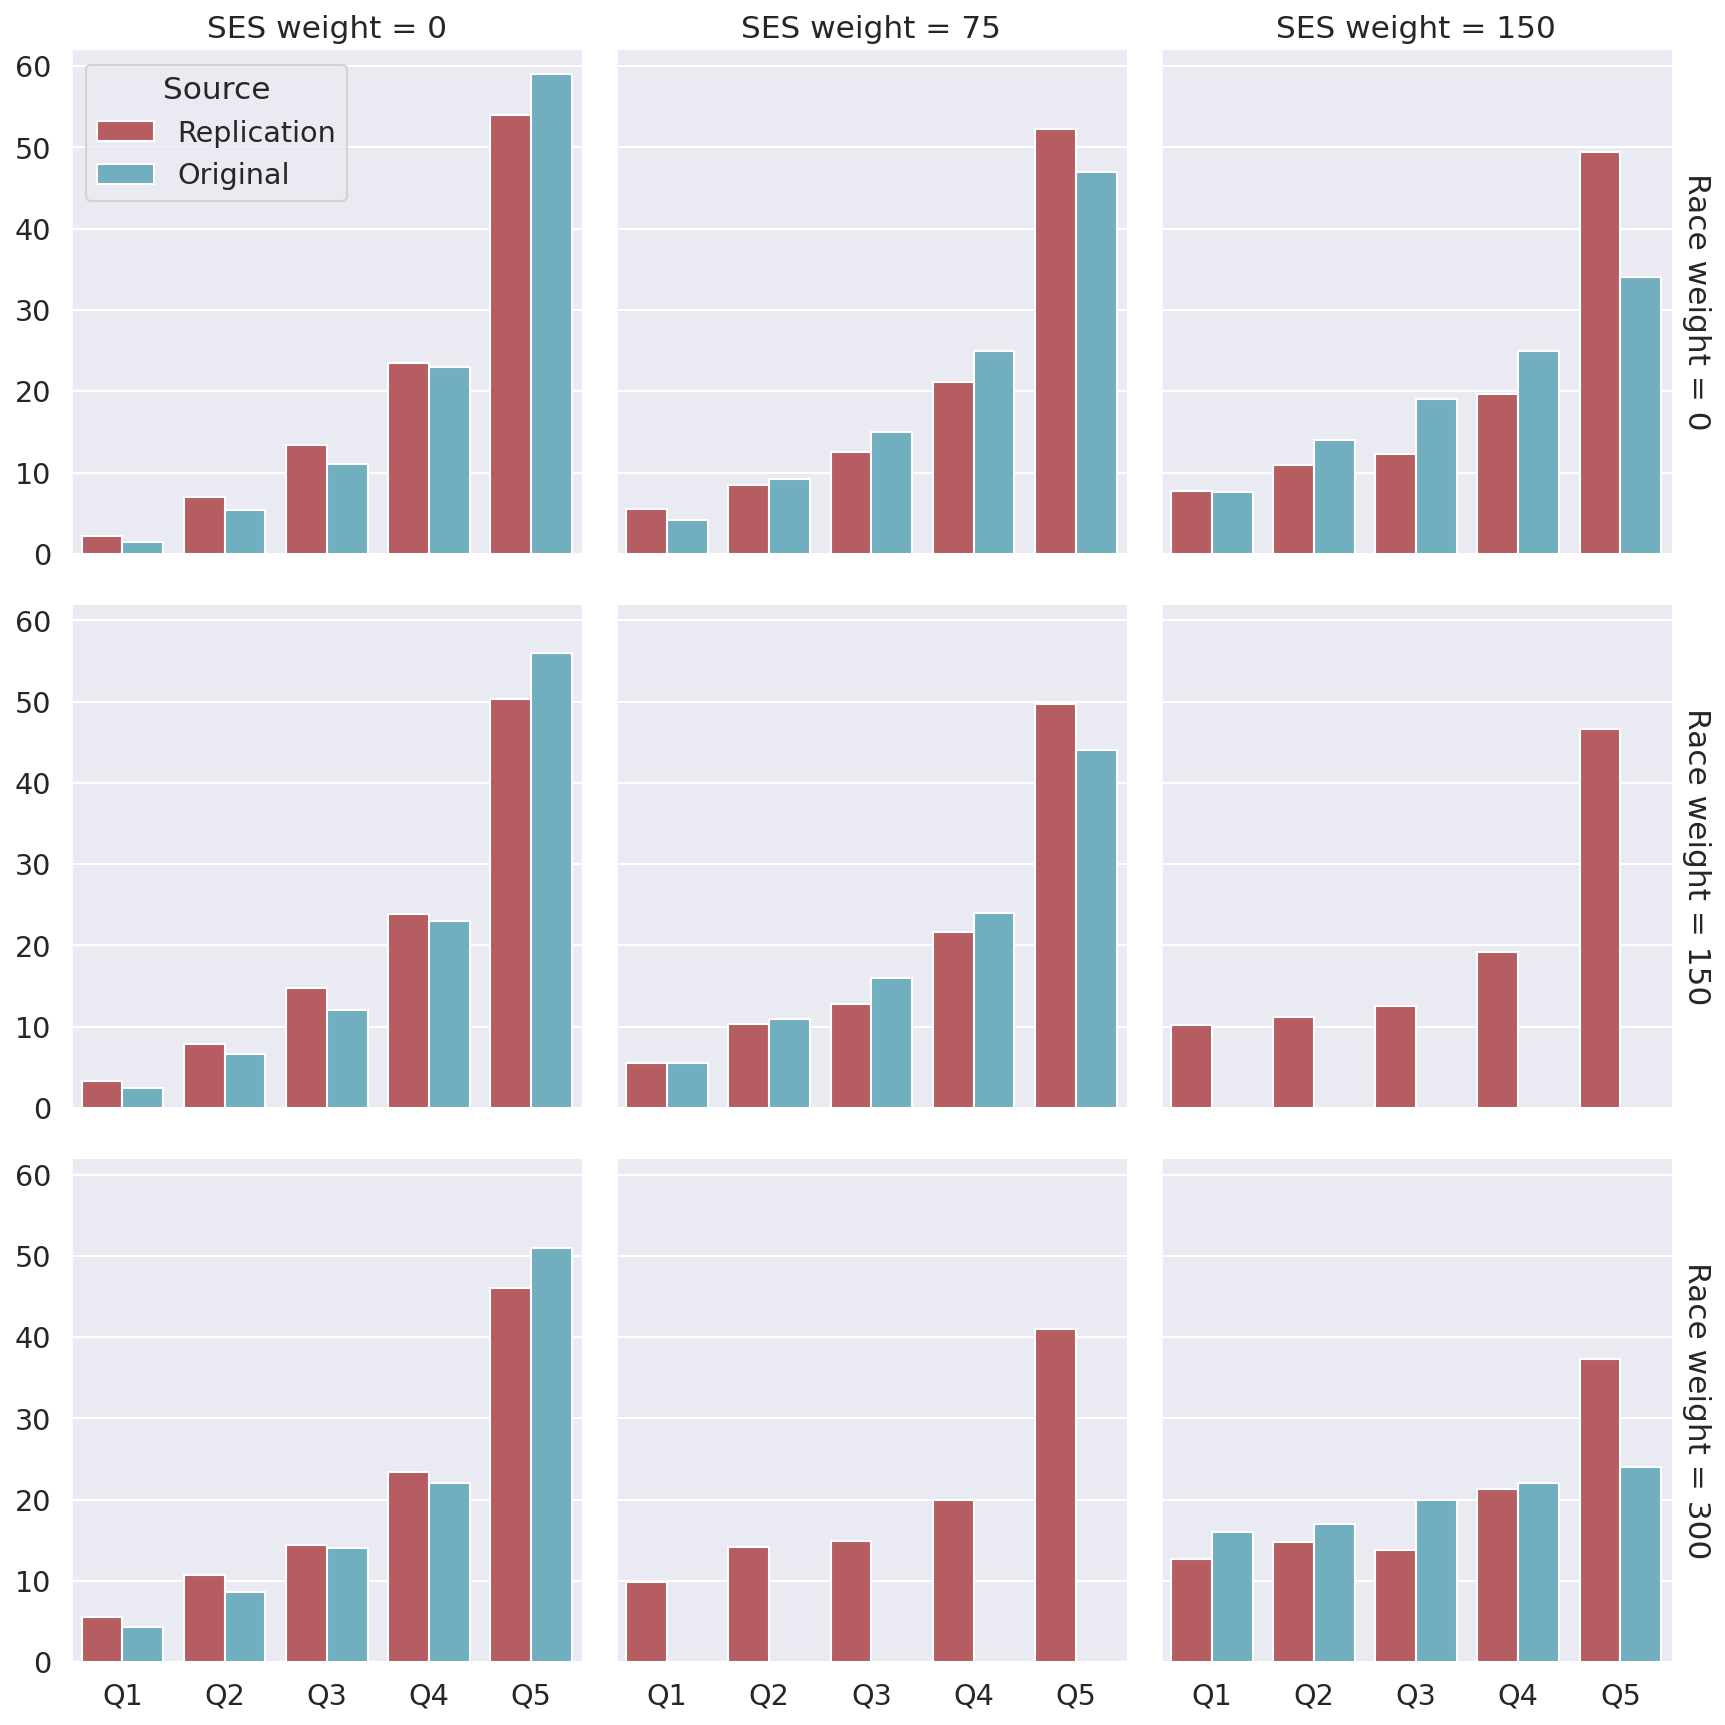

In [19]:
g = sns.catplot(
    x="Resources",
    y="Composition (%)",
    hue="Source",
    col="SES weight",
    row="Race weight",
    data=df_figA5,
    kind="bar",
    margin_titles=True,
    legend_out=False,
    height=4,
    palette=["#c44e52", "#64b5cd"],
)
g.set_axis_labels("", "")
g.figure.savefig("figures/figA5.png")